# Recurrent Neural Net Part 2

This notebook is based on a tutorial: "Multivariate Time Series using RNN with Keras" from [here](https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679)



## Meeting Agenda



1.   Project Updates

- Phil 
  - https://www.edx.org/bio/robert-van-de-geijn
  - Pink Zybo - board that executes Python on an FPGA - [pynq.io](https://pynq.io)

- Chuck - IBM Watson templates - learning Python

- J - RNN for soil moisture prediction

- Nick - Web app called "Improved Initiative" - manages attributes of D&D characters. Nick working on importing stat blocks.

- Phil - MDA Small Business Conference June 25-26

2.   SBIR Brainstorm Session Updates

 - MDA 19-005 Topic
 - MDA 19-011 Topic
 - Additional session to follow tonight
 
3.   RNN Code Walkthrough


## RNN Example Code

In [2]:
import numpy as np
import pandas as pd
import math
from keras import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


First, we download a csv export of the Google stock from [here](https://www.nasdaq.com/symbol/goog/historical).

For convenience, this is saved in the presentations repository and can be access by URL.

**Note:** 

We need to use the thousands=',' parameter in order to ignore the commas in the numbers when converting to floats.

We'll use the head() method to get a look at what the dataframe looks like.

In [3]:
fileURL = "https://github.com/HSV-AI/presentations/raw/master/2019/190619/HistoricalQuotes.csv"
stock_data = pd.read_csv(fileURL, thousands=',')
stock_data.head(2)

,date,close,volume,open,high,low
0,16:00,1103.6,1386584.0,1107.82,1116.39,1098.99
1,2019/06/18,1103.6,1386684.0,1109.69,1116.39,1098.99


In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 6 columns):
date      1260 non-null object
close     1260 non-null float64
volume    1260 non-null float64
open      1260 non-null float64
high      1260 non-null float64
low       1260 non-null float64
dtypes: float64(5), object(1)
memory usage: 59.1+ KB


In [5]:

stock_data["average"] = (stock_data["high"] + stock_data["low"])/2
stock_data.head(5)


,date,close,volume,open,high,low,average
0,16:00,1103.6,1386584.0,1107.82,1116.39,1098.99,1107.69
1,2019/06/18,1103.6,1386684.0,1109.69,1116.39,1098.99,1107.69


In [7]:
input_feature= stock_data.iloc[:,[2,6]].values
input_data = input_feature
input_feature.shape

output_feature = stock_data.iloc[:,3].values

print(input_feature.shape)
print(output_feature.shape)

(1260, 2)
(1260,)


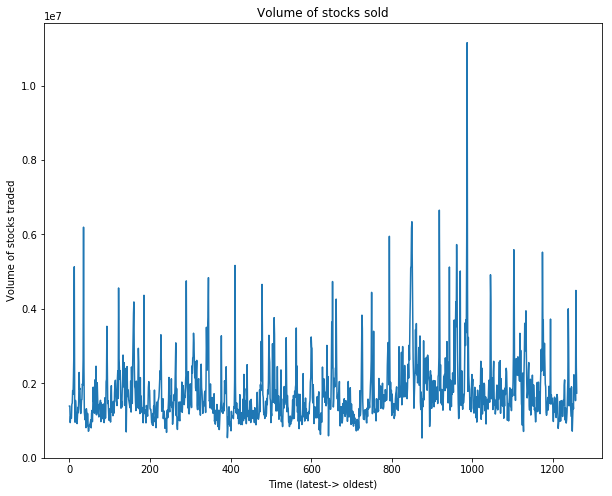

In [8]:
plt.figure(figsize=(10,8))
plt.plot(input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()

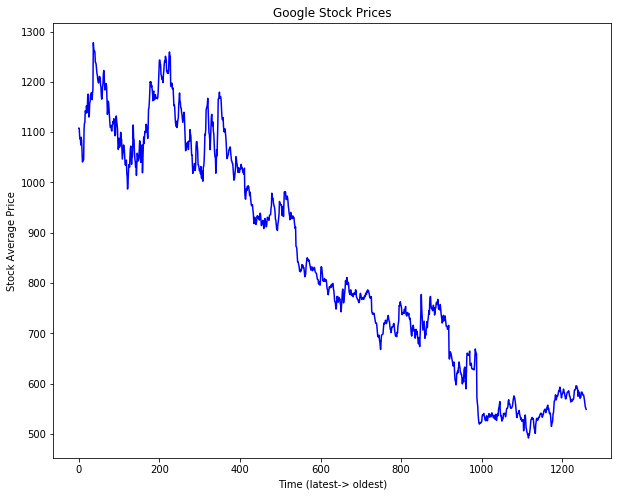

In [9]:
plt.figure(figsize=(10,8))
plt.plot(input_feature[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Average Price")
plt.show()

In [0]:
input_scaler = MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = input_scaler.fit_transform(input_feature[:,:])

output_scaler = MinMaxScaler(feature_range=(0,1))
output_feature = output_feature.reshape(-1, 1)
output_data = output_scaler.fit_transform(output_feature)

In [0]:
lookback= 50

X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])

    X.append(t)
    y.append(output_data[i+ lookback])

In [12]:
X, y= np.array(X), np.array(y)
X = X.reshape(X.shape[0],lookback, 2)
print(X.shape)
print(y.shape)

(1209, 50, 2)
(1209, 1)


In [51]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='mean_squared_error')

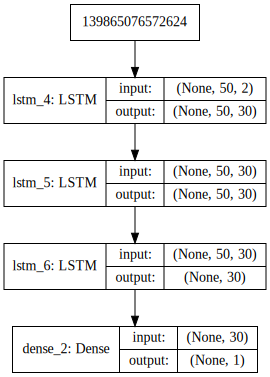

In [53]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
def plot_loss(history):

  length = len(history.history['loss'])
  rng = range(length)

  training_fit = np.polyfit(rng, history.history['loss'], 1)
  training_trend = np.poly1d(training_fit)

  val_fit = np.polyfit(rng, history.history['val_loss'], 1)
  val_trend = np.poly1d(val_fit)

  plt.figure(figsize=(10,8))
  plt.plot(history.history['loss'], color='green')
  plt.plot(training_trend(rng), color='green', linestyle='--')
  plt.plot(history.history['val_loss'], color='orange')
  plt.plot(val_trend(rng), color='orange', linestyle='--')

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Training Trend', 'Validation', 'Validation Trend'], loc='lower left')
  plt.show()


Originally, we had this line:

history = model.fit(X, y, validation_split=0.30, epochs=50, batch_size=32, verbose=1)

The problem is that the validation split always takes the validation off of the back of the data, instead of randomly selecting 30% for validation.

To change this up, we will use the train_test_split from sklearn to give us a random 30% validation set. Then we will train for 50 epochs and graph the training loss and validation loss to see how we're doing.

We will repeat this for a few times to see how low the error drops.


Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 9s 11ms/step - loss: 0.0728 - val_loss: 0.0109
Epoch 2/50
846/846 [==============================] - 7s 8ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 3/50
846/846 [==============================] - 7s 8ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 4/50
846/846 [==============================] - 7s 8ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 5/50
846/846 [==============================] - 7s 8ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 6/50
846/846 [==============================] - 7s 8ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 7/50
846/846 [==============================] - 7s 8ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/50
846/846 [==============================] - 7s 8ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/50
846/846 [==============================] - 7s 8ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/50
846/846 [==============================] 

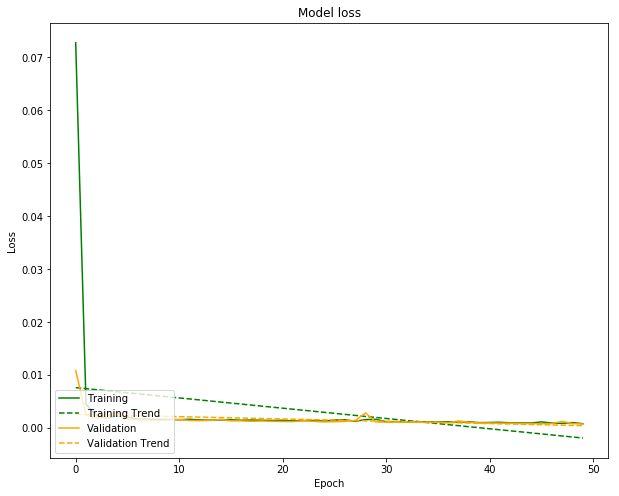

Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 7s 8ms/step - loss: 8.6388e-04 - val_loss: 8.2170e-04
Epoch 2/50
846/846 [==============================] - 7s 8ms/step - loss: 8.7273e-04 - val_loss: 7.7637e-04
Epoch 3/50
846/846 [==============================] - 7s 8ms/step - loss: 8.2011e-04 - val_loss: 7.9065e-04
Epoch 4/50
846/846 [==============================] - 7s 8ms/step - loss: 7.8985e-04 - val_loss: 8.5200e-04
Epoch 5/50
846/846 [==============================] - 7s 8ms/step - loss: 9.3358e-04 - val_loss: 0.0010
Epoch 6/50
846/846 [==============================] - 7s 8ms/step - loss: 9.2415e-04 - val_loss: 8.1086e-04
Epoch 7/50
846/846 [==============================] - 7s 8ms/step - loss: 9.9049e-04 - val_loss: 7.0884e-04
Epoch 8/50
846/846 [==============================] - 7s 8ms/step - loss: 7.5658e-04 - val_loss: 9.4600e-04
Epoch 9/50
846/846 [==============================] - 7s 8ms/step - loss: 7.4550e-04 - val_los

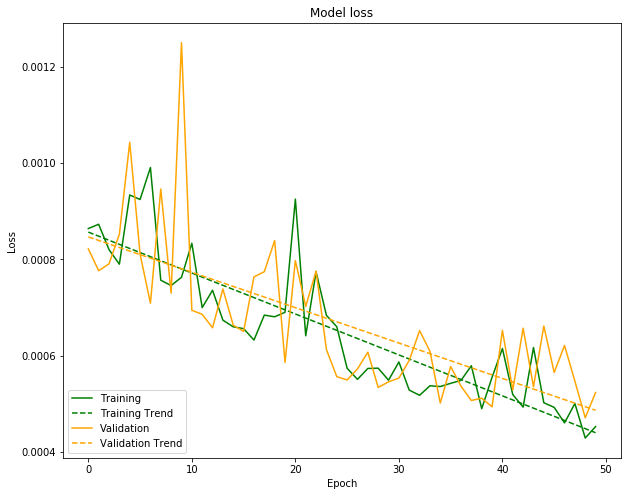

Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 7s 8ms/step - loss: 5.8776e-04 - val_loss: 3.9605e-04
Epoch 2/50
846/846 [==============================] - 7s 8ms/step - loss: 5.5502e-04 - val_loss: 4.5243e-04
Epoch 3/50
846/846 [==============================] - 7s 8ms/step - loss: 4.8582e-04 - val_loss: 5.2956e-04
Epoch 4/50
846/846 [==============================] - 7s 8ms/step - loss: 6.4468e-04 - val_loss: 6.0070e-04
Epoch 5/50
846/846 [==============================] - 7s 8ms/step - loss: 4.4890e-04 - val_loss: 3.9060e-04
Epoch 6/50
846/846 [==============================] - 7s 8ms/step - loss: 4.8351e-04 - val_loss: 4.0960e-04
Epoch 7/50
846/846 [==============================] - 7s 8ms/step - loss: 4.3280e-04 - val_loss: 3.8860e-04
Epoch 8/50
846/846 [==============================] - 7s 8ms/step - loss: 4.4338e-04 - val_loss: 3.8876e-04
Epoch 9/50
846/846 [==============================] - 7s 8ms/step - loss: 4.6279e-04 - val

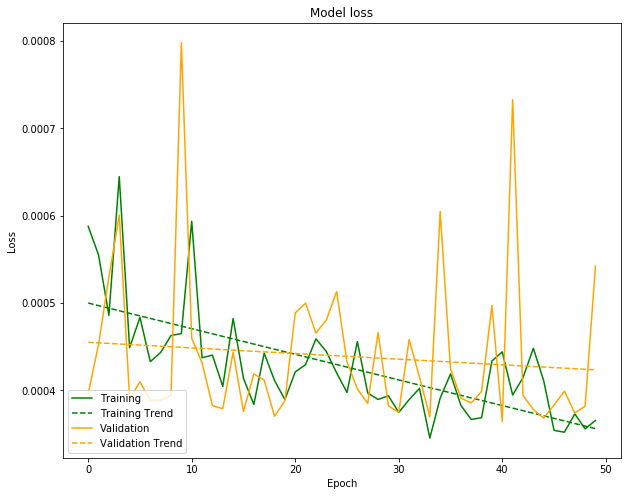

In [55]:
from sklearn.model_selection import train_test_split
total_training = []
total_validation = []

for i in range(3):
  XTraining, XValidation, YTraining, YValidation = train_test_split(X,y,test_size=0.3) # before model building
  history = model.fit(XTraining, YTraining, batch_size=32, epochs=50, validation_data=(XValidation,YValidation))
  total_training.append(history.history['loss'])
  total_validation.append(history.history['val_loss'])
  
  # Plot training & validation loss values
  plot_loss(history)


In [58]:
length = len(total_training)
rng = range(length)

training_fit = np.polyfit(rng, total_training, 1)
training_trend = np.poly1d(training_fit)

val_fit = np.polyfit(rng, total_validation, 1)
val_trend = np.poly1d(val_fit)

plt.figure(figsize=(10,8))
plt.plot(total_training, color='green')
plt.plot(training_trend(rng), color='green', linestyle='--')
plt.plot(total_validation, color='orange')
plt.plot(val_trend(rng), color='orange', linestyle='--')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Training Trend', 'Validation', 'Validation Trend'], loc='lower left')
plt.show()


ValueError: ignored

In [0]:
predicted_value = model.predict(X)
unscaled_output = output_scaler.inverse_transform(predicted_value)

temp = np.array(stock_data.open[lookback:-1]).reshape(-1,1)


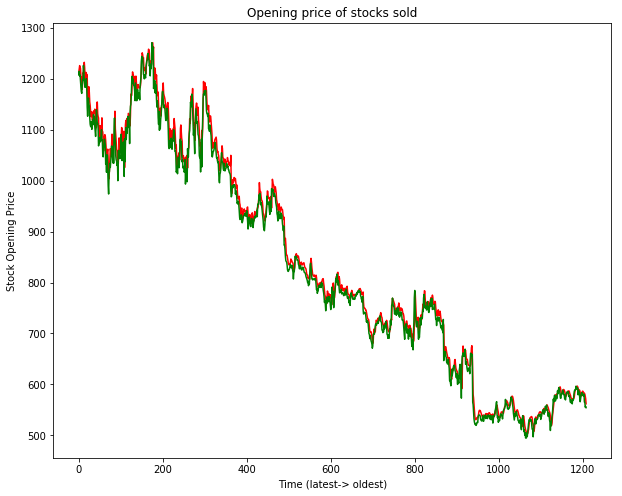

In [57]:

plt.figure(figsize=(10,8))
plt.plot(unscaled_output, color= 'red')
plt.plot(temp, color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()